# Implementation of Dynamic Ensemble Selection
1. K-Nearest Oracles (KNORA) Elimminate and Union
2. Meta Learning for Dynamic Ensemble Selection (METADES)

In [1]:
#Library for Raster data processing
import rasterio
#Library for numerical and spatial data processing
import numpy as np
from numpy import mean
from numpy import std
import geopandas as gpd
import pandas as pd
#library for plotting 
import matplotlib.pyplot as plt
#Library for saving fitted model
import joblib
#Library for Dynamic Ensemble Selection
import deslib
#import DES techniques from DESlib
from deslib.des.des_p import DESP
from deslib.des.knora_u import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.des.meta_des import METADES
#Accuracy Assessment Metrics
from sklearn.metrics import log_loss, accuracy_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.utils import shuffle

**Importing the Raster data**

In [2]:
#importing the raster data
raster_file = 'C:/Master of Remote Sensing/Master Research/Data and Maps/Imagery 2/Landsat 9/Landsat_Combine_Param_final.tif'
dataset = rasterio.open(raster_file)
# Bands Names
desc = dataset.descriptions
print('Raster description: {desc}\n'.format(desc=desc))    
#inspecting the raste file. The format is bands,row, column
L9_MS = dataset.read()
L9_MS.shape
#tranpose the data into the form of row, column, bands
L9_MS = L9_MS.transpose(1, 2, 0)
L9_MS.shape

Raster description: ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'elevation', 'slope', 'TWI', 'FlowA', 'aspect', 'brightness', 'greenness', 'wetness', 'TCA', 'NDVI', 'BUI', 'MNDWI', 'EVI')



(1811, 1325, 21)

**Sample Extraction from Shapefile**

In [3]:
from rasterio.mask import mask
#adding the training data
sample = gpd.read_file('C:/Master of Remote Sensing/Master Research/Data and Maps/Shapefile/Training Data/Landsat9TD/Combine_TD/FINALTD_Combine_RBI_ver_FINALFIXS.shp')
sample.head()

,CLASS_ID,CLASS_NAME,AREA,ID2,geometry
0,9,BP,16.0,0,"POLYGON ((816240 9196950, 816210 9196950, 8162..."
1,16,SW,10.0,19,"POLYGON ((808440 9196830, 808350 9196830, 8083..."
2,16,SW,12.0,19,"POLYGON ((812040 9196800, 811980 9196800, 8119..."
3,8,BPP,5.0,1,"POLYGON ((820110 9196770, 820050 9196770, 8200..."
4,21,HLT,21.0,4,"POLYGON ((800280 9196710, 800220 9196710, 8002..."


In [4]:
#Sample extraction function
def extract_pixels_from_shapefile(shapefile, raster):
    training_samples = []
    for index, row in shapefile.iterrows():
        geometry = [row['geometry']]
        id_class = row['ID2']

        # Raster masking for extracting the pixel in the shapefile
        out_image, out_transform = mask(raster, geometry, crop=True)

        # Output bands
        out_image = out_image.reshape(raster.count, -1).T  

        # Invalid pixel handling
        valid_pixels = out_image[~np.isnan(out_image).any(axis=1)]

        # Handling valid pixel as the training data
        for pixel in valid_pixels:
            training_samples.append((pixel, id_class))

    # Converts the tuple list into numpy array
    features = np.array([sample[0] for sample in training_samples])  # Extract pixel values (features)
    labels = np.array([sample[1] for sample in training_samples])    # Extract class labels
    return features, labels

# Extracting the sample from shapefile
features, labels = extract_pixels_from_shapefile(sample, dataset)
print(features.shape)
print(labels.shape)
#Masking out invalid pixels
nan_mask = np.isnan(features).any(axis=1) | np.isnan(labels)
features = features[~nan_mask]
labels = labels[~nan_mask]
#Pixel counting
sample_new = pd.DataFrame({'class': labels})
print(sample_new['class'].value_counts())

(20655, 21)
(20655,)
4     3228
19    2288
10    1842
14    1811
13    1676
17    1566
8     1197
3     1162
15    1136
16    1069
0     1063
18     625
7      498
2      419
6      261
11     229
5      151
9      134
1      120
12     102
20      78
Name: class, dtype: int64


**Training and Testing Split**
Two stage of training data spliting:
1. First stage is for the pool classifiers training data (x_train, y_train)
2. Second stage, splitting the already splitted training data (x_train, y_train) into training data which will be used for DES model prediction (x_dsel, y_dsel)

In [5]:
from sklearn.model_selection import train_test_split
# Split data: 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)
print('Testing data ', x_test.shape, y_test.shape)
# Split the data into training and DSEL for DS techniques
x_train, x_dsel, y_train, y_dsel = train_test_split(x_train, y_train, stratify=y_train, test_size=0.3, random_state=42)
print("Training data for DES", x_dsel.shape, y_dsel.shape)
print('Training data for the pool classifiers', x_train.shape, y_train.shape)

#calculate the class distribution of pixels
un_class_train, class_count_train = np.unique(y_train, return_counts=True)
un_class_dsel, class_count_dsel = np.unique(y_dsel, return_counts=True)
un_class_test, class_count_test = np.unique(y_test, return_counts=True )
# Correct the union of unique classes for all datasets
all_classes = np.unique(np.concatenate([un_class_train, un_class_dsel, un_class_test]))

# Create the DataFrame for class pixel counts
class_pixel_count = pd.DataFrame({
    'Class': all_classes,
    'Pool Training Data': [
        class_count_train[un_class_train.tolist().index(cls)] if cls in un_class_train else 0
        for cls in all_classes
    ],
    'DES Training Data': [
        class_count_dsel[un_class_dsel.tolist().index(cls)] if cls in un_class_dsel else 0
        for cls in all_classes
    ],
    'Test Pixel': [
        class_count_test[un_class_test.tolist().index(cls)] if cls in un_class_test else 0
        for cls in all_classes
    ]
})

# Display the resulting DataFrame
print(class_pixel_count)
class_pixel_count.to_csv('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/train_test_knora.csv')

Testing data  (4131, 21) (4131,)
Training data for DES (4958, 21) (4958,)
Training data for the pool classifiers (11566, 21) (11566,)
    Class  Pool Training Data  DES Training Data  Test Pixel
0       0                 595                255         213
1       1                  67                 29          24
2       2                 235                100          84
3       3                 651                279         232
4       4                1807                775         646
5       5                  85                 36          30
6       6                 146                 63          52
7       7                 279                119         100
8       8                 671                287         239
9       9                  75                 32          27
10     10                1032                442         368
11     11                 128                 55          46
12     12                  57                 25          20
13     13   

**Pool Classifiers Model Initialization**
Pool classifiers could be homgenous or heterogenous, but diversity is crucial
The Pool classifiers used are as follows:
1. XGBoost
2. Light GBM
3. Gaussian Naive Bayes
4. Extremely Randomized Trees
5. Multilayer Perceptron
6. Random Forest
7. Logistic Regression

In [6]:
#Import the library for the pool classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostClassifier

#Initialize the model 
init_xgb = XGBClassifier(n_estimators = 900, min_child_weight = 3, max_depth = 6,
                         subsample = 0.5, learning_rate = 0.1, colsample_bytree = 0.5,  random_state=42)
init_xgb.fit(x_train, y_train)
init_lgb = LGBMClassifier(n_estimators=700, num_leaves=127, min_data_in_leaf = 5, max_depth=10, 
                          max_bin = 63, learning_rate=0.1, random_state=42)
init_lgb.fit(x_train, y_train)
init_rf = RandomForestClassifier(n_estimators=900, min_samples_split=2, min_samples_leaf=5, max_samples=0.5, 
                                 max_features = 'log2', max_depth= None, random_state=42)
init_rf.fit(x_train, y_train)
init_et = ExtraTreesClassifier(n_estimators=900, min_samples_split=13, min_samples_leaf=9, 
                               max_features= 'sqrt', max_depth=30, bootstrap=False, random_state=42)
init_et.fit(x_train, y_train)
init_mlp = MLPClassifier(hidden_layer_sizes=(500, 100), early_stopping=True, max_iter=1000, 
                         learning_rate='adaptive', learning_rate_init=0.001, random_state=42)
init_mlp.fit(x_train, y_train)
init_nb = GaussianNB(var_smoothing=0.0002811768697974231)
init_nb.fit(x_train, y_train)
init_lr = LogisticRegression(max_iter=1000)
init_lr.fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1323
[LightGBM] [Info] Number of data points in the train set: 11566, number of used features: 21
[LightGBM] [Info] Start training from score -2.967264
[LightGBM] [Info] Start training from score -5.151132
[LightGBM] [Info] Start training from score -3.896240
[LightGBM] [Info] Start training from score -2.877315
[LightGBM] [Info] Start training from score -1.856402
[LightGBM] [Info] Start training from score -4.913174
[LightGBM] [Info] Start training from score -4.372218
[LightGBM] [Info] Start train

c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

**Hyperparameter Tuning using Randomized Search**

This could be change to Grid Search, but due to limitted computation, randomized search is utilized 

In [7]:
#Parameter Grid Definition
ET_param = {
    'n_estimators' : [500, 700, 900],
    'max_depth': [3, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 13],
    'min_samples_leaf': [1, 3, 7, 9],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
et_model = ExtraTreesClassifier(random_state=42)
xgb_param = {
    'n_estimators': [300, 500, 700, 900],
    'max_depth': [3, 6, 15, 20],
    'min_child_weight': [1, 3, 9, 13],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.1, 0.5, 1.0] 
}
xgb_model = XGBClassifier(objective='multi:softprob', num_class = 21, eval_metric = 'mlogloss', random_state=42)
lgb_param = {
    'n_estimators': [300, 500, 700, 900],
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'min_data_in_leaf': [5, 10, 20, 30],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 3, 10, 15],
    'max_bin': [63, 127, 255],
}
lgb_model = LGBMClassifier(objective= 'multiclass',  num_class = 21, 
                            boosting_type='gbdt', metric = 'multi_logloss')
rf_param = {
    'n_estimators': [300, 500, 700, 900],
    'max_depth': [3, 7, 9, None],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_samples': [0.3, 0.5, 1],
    'max_features': [None, 'sqrt', 'log2']
}
rf_model = RandomForestClassifier(random_state=42)
mlp_param = {
    'hidden_layer_sizes': [(500, 100), (400, 200)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.2]
}
mlp_model = MLPClassifier(random_state=42, early_stopping=True)

nb_param = {
    'var_smoothing': np.logspace(-6, -1, num=50)
}
nb_model= GaussianNB()
lr_param = {
    'penalty':['l1','l2'],
    'C' :[100, 10, 1.0, 0.1],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter'  : [1000]
}
cb_param_grid = {
              'depth': [2, 6, 8],
              'l2_leaf_reg': [2, 5],
              'bagging_temperature': [0, 0.5],
              'learning_rate': [0.05, 0.01, 0.1],
              'border_count': [64, 128],
              'rsm': [0.1, 0.5, 1]
}
catboostmodel = CatBoostClassifier(random_state=42, early_stopping_rounds=10, eval_metric='MultiClass' )


In [ ]:
import time
# Start the timer
start_time = time.time()
#A list to store the result
results = []
#XGBoost
xgb_rcv = RandomizedSearchCV(xgb_model, xgb_param, cv=10, scoring='accuracy', n_jobs=-1, verbose=3)
xgb_rcv.fit(x_train, y_train)
#Get the best estimator
best_xgb = xgb_rcv.best_estimator_
joblib.dump(best_xgb,'C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/Pool_BestXGB.pkl')
#Store the result to list
results.append({
    'Classifier': 'XGBoost',
    'Best CV Accuracy': xgb_rcv.best_score_,
    'Best Params': xgb_rcv.best_params_,
})
#Random Forest
#rf_rcv = RandomizedSearchCV(rf_model, rf_param, cv=10, n_jobs=-1, scoring='accuracy', verbose=3)
#rf_rcv.fit(x_train, y_train)
#best_rf = rf_rcv.best_estimator_
#results.append({
#    'Classifier': 'Random Forest',
#    'Best CV Accuracy': rf_rcv.best_score_,
#    'Best Params': rf_rcv.best_params_,
#})
#joblib.dump(best_rf,'C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/Pool_BestRF.pkl')
#Light GBM
lgb_rcv = RandomizedSearchCV(init_lgb, lgb_param, cv=10, scoring='accuracy', n_jobs=-1, verbose=3)
lgb_rcv.fit(x_train, y_train)
best_lgb = lgb_rcv.best_estimator_
joblib.dump(best_lgb,'C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/Pool_Bestlgb.pkl')
results.append({
    'Classifier': 'LightGBM',
    'Best CV Accuracy': lgb_rcv.best_score_,
    'Best Params': lgb_rcv.best_params_
})
#MLP
mlp_rcv = RandomizedSearchCV(mlp_model, mlp_param, cv=10, scoring='accuracy', verbose=3)
mlp_rcv.fit(x_train, y_train)
best_mlp = mlp_rcv.best_estimator_
joblib.dump(best_mlp,'C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/Pool_BestMLP.pkl')
results.append({
    'Classifier': 'MLP',
    'Best CV Accuracy': mlp_rcv.best_score_,
    'Best Params': mlp_rcv.best_estimator_
})
#Gausian Naive Bayes
#nb_rcv = RandomizedSearchCV(nb_model, nb_param, cv=10, scoring='accuracy', verbose=10)
#nb_rcv.fit(x_train, y_train)
#best_nb = nb_rcv.best_estimator_
#results.append({
#    'Classifier': 'Naive Bayes Gaussian',
#    'Best CV Accuracy': nb_rcv.best_score_,
#    'Best Params': nb_rcv.best_params_
#})
et_rcv = RandomizedSearchCV(et_model, ET_param, cv=10, scoring='accuracy', n_jobs=-1, verbose=10, error_score='raise')
et_rcv.fit(x_train, y_train)
best_et = et_rcv.best_estimator_
joblib.dump(best_et,'C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/Pool_BestMLP.pkl')
print(et_rcv.best_score_)
results.append({
    'Classifier': 'Extra Trees',
    'Best Accuracy': et_rcv.best_score_,
    'Best Params': et_rcv.best_params_
})
# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

# saving the dataframe
#results_df.to_csv('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/Randomsearch_Pool_Knora_rev_again.csv')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Pool classifiers Tuning Time: {elapsed_time:.3f} seconds")
#Pool classifiers Tuning Time: 1944.652 seconds

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1323
[LightGBM] [Info] Number of data points in the train set: 11566, number of used features: 21
[LightGBM] [Info] Start training from score -2.967264
[LightGBM] [Info] Start training from score -5.151132
[LightGBM] [Info] Start training from score -3.896240
[LightGBM] [Info] Start training from score -2.877315
[LightGBM] [Info] Start training from score -1.856402
[LightGBM] [Info] Start training from score -4.913174
[LightGBM] [Info]

In [14]:
param_grid = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : [5, 7, 9, 13,15],
    'solver': ['newton-cg','liblinear','sag','saga'],
    'max_iter'  : [1500, 2500, 5000]
}
]
lr = LogisticRegression()
lr_rcv = RandomizedSearchCV(lr, param_grid, cv=10, scoring='accuracy', verbose=10)
lr_rcv.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START C=15, max_iter=2500, penalty=l2, solver=liblinear.........
[CV 1/10; 1/10] END C=15, max_iter=2500, penalty=l2, solver=liblinear;, score=0.466 total time=  11.7s
[CV 2/10; 1/10] START C=15, max_iter=2500, penalty=l2, solver=liblinear.........
[CV 2/10; 1/10] END C=15, max_iter=2500, penalty=l2, solver=liblinear;, score=0.489 total time=   9.9s
[CV 3/10; 1/10] START C=15, max_iter=2500, penalty=l2, solver=liblinear.........
[CV 3/10; 1/10] END C=15, max_iter=2500, penalty=l2, solver=liblinear;, score=0.484 total time=  11.7s
[CV 4/10; 1/10] START C=15, max_iter=2500, penalty=l2, solver=liblinear.........
[CV 4/10; 1/10] END C=15, max_iter=2500, penalty=l2, solver=liblinear;, score=0.487 total time=  11.3s
[CV 5/10; 1/10] START C=15, max_iter=2500, penalty=l2, solver=liblinear.........
[CV 5/10; 1/10] END C=15, max_iter=2500, penalty=l2, solver=liblinear;, score=0.472 total time=  10.3s
[CV 6/10; 1/10] S

c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.239 total time=  45.0s
[CV 2/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga..............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.263 total time=  45.2s
[CV 3/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga..............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.254 total time=  44.9s
[CV 4/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga..............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.261 total time=  45.1s
[CV 5/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga..............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.248 total time=  49.0s
[CV 6/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga..............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.252 total time=  47.2s
[CV 7/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga..............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.244 total time=  46.4s
[CV 8/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga..............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.260 total time=  45.9s
[CV 9/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga..............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.247 total time=  47.3s
[CV 10/10; 9/10] START C=15, max_iter=2500, penalty=l2, solver=saga.............


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\62853\AppData\Local\Prog

[CV 10/10; 9/10] END C=15, max_iter=2500, penalty=l2, solver=saga;, score=0.266 total time=  46.3s
[CV 1/10; 10/10] START C=13, max_iter=5000, penalty=elasticnet, solver=sag......
[CV 1/10; 10/10] END C=13, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/10; 10/10] START C=13, max_iter=5000, penalty=elasticnet, solver=sag......
[CV 2/10; 10/10] END C=13, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/10; 10/10] START C=13, max_iter=5000, penalty=elasticnet, solver=sag......
[CV 3/10; 10/10] END C=13, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/10; 10/10] START C=13, max_iter=5000, penalty=elasticnet, solver=sag......
[CV 4/10; 10/10] END C=13, max_iter=5000, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/10; 10/10] START C=13, max_iter=5000, penalty=elasticnet, solver=sag......
[CV 5/10; 10/10] END C=13, max_iter=5000, penalty=elasticnet, solver=sag;, score

RandomizedSearchCV(cv=10, estimator=LogisticRegression(),
                   param_distributions=[{'C': [5, 7, 9, 13, 15],
                                         'max_iter': [1500, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     'none'],
                                         'solver': ['newton-cg', 'liblinear',
                                                    'sag', 'saga']}],
                   scoring='accuracy', verbose=10)

**Load the Model**

In [16]:
#Load the previously saved Randomsearch result
xgbmodel = joblib.load('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/XGB_RCV_fullDES.pkl')
rfmodel = joblib.load( 'C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/RF_RCV_fullDES.pkl')
lgbmodel = joblib.load('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/LGB_rcv_fullDES.pkl') 
mlpmodel = joblib.load('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/MLP_RCV_fullDES.pkl')
nbmodel = joblib.load('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/NB_RCV_DES.pkl')
etmodel = joblib.load('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/ET_RCV_fullDES.pkl')

#Called the best estimator
bestxgb = xgbmodel.best_estimator_
bestrf = rfmodel.best_estimator_
bestlgb = lgbmodel.best_estimator_
bestmlp = mlpmodel.best_estimator_
bestnb = nbmodel.best_estimator_
bestet = etmodel.best_estimator_


**Dynamic Ensemble Selection**

>2 0.625 (0.020)
>3 0.618 (0.022)
>4 0.612 (0.020)
>5 0.606 (0.023)
>6 0.609 (0.019)
>7 0.609 (0.020)
>8 0.607 (0.020)
>9 0.604 (0.019)
>10 0.605 (0.018)
>11 0.603 (0.021)
>12 0.599 (0.017)
>13 0.601 (0.018)
>14 0.601 (0.020)
>15 0.601 (0.023)
>16 0.601 (0.021)
>17 0.605 (0.022)
>18 0.604 (0.022)
>19 0.601 (0.020)
>20 0.599 (0.020)
>21 0.602 (0.018)


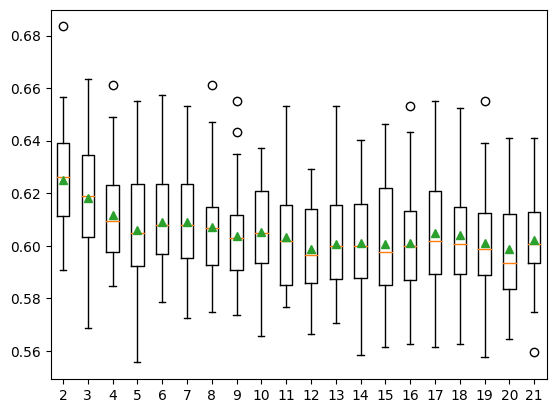

In [37]:
#Function for Evaluating the number of k-neighbor in KNORAU
def get_models():
	models = dict()
	for n in range(2,22):
		models[str(n)] = KNORAE(k=n, DFP=True, voting='soft')
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, x_dsel, y_dsel, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [31]:
#Store the pool classifier best estimator in the form of list
best_lr = lr_rcv.best_estimator_
pool_clf = [bestxgb,  bestet, bestmlp]
#pool_clf = [init_xgb, init_lgb, init_et, init_mlp]
knora_result = []

#K-Nearest Oracles-Union
knorau = KNORAU(pool_classifiers=pool_clf, k=15, DFP=True, voting='soft')
knorau.fit(x_dsel, y_dsel)
y_pred = knorau.predict(x_test)
y_probab_u = knorau.predict_proba(x_test)
knora_result.append({
    'Classifier': 'KNORA-U',
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred, average='weighted'),
})
#K-Nearest Oracles-Eliminate
knorae = KNORAE(pool_classifiers=pool_clf, k=15, DFP=True, voting='soft', DSEL_perc = 0.1)
knorae.fit(x_dsel, y_dsel)
y_pred_e = knorae.predict(x_test)
y_prob_e = knorae.predict_proba(x_test)
knora_result.append({
    'Classifier': 'KNORA-E',
    'Accuracy': accuracy_score(y_test, y_pred_e),
    'F1-Score': f1_score(y_test, y_pred_e, average='weighted'),
    })
#METADES
metades = METADES(pool_classifiers=pool_clf, k=7, DFP=True, voting='soft', Hc=0.5, DSEL_perc = 0.1)
metades.fit(x_dsel, y_dsel)
y_pred_des = metades.predict(x_test)
y_prob_des = metades.predict_proba(x_test)
knora_result.append({
    'Classifier': 'METADES',
    'Accuracy': accuracy_score(y_test, y_pred_des),
    'F1-Score': f1_score(y_test, y_pred_des, average='weighted'),
    })
knora_result_df = pd.DataFrame(knora_result)
print(knora_result_df)
#Full model 
#Classification accuracy KNORA-Union:  0.7124183006535948
#Classification accuracy of KNORA Eliminate: 0.7131445170660857
#Remove LR
#Classification accuracy KNORA-Union:  0.7143548777535705
#Classification accuracy of KNORA Eliminate: 0.7143548777535705
#Remove RF
#Classification accuracy KNORA-Union:  0.7158073105785524
#Classification accuracy of KNORA Eliminate: 0.7165335269910433

  Classifier  Accuracy  F1-Score
0    KNORA-U  0.714839  0.748318
1    KNORA-E  0.716534  0.750327
2    METADES  0.714839  0.748466


In [55]:
joblib.dump(knorae,'C:/Master of Remote Sensing/Python Code/RFECV_L9/KNORAE.pkl',  compress=('zlib', 3))
joblib.dump(metades,'C:/Master of Remote Sensing/Python Code/RFECV_L9/METADES.pkl',  compress=('zlib', 3))

['C:/Master of Remote Sensing/Python Code/RFECV_L9/METADES.pkl']

In [56]:
# Check for empty y_dsel
if len(y_dsel) == 0:
    print("Error: y_dsel is empty. Please check your data loading or preprocessing.")
    exit()

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

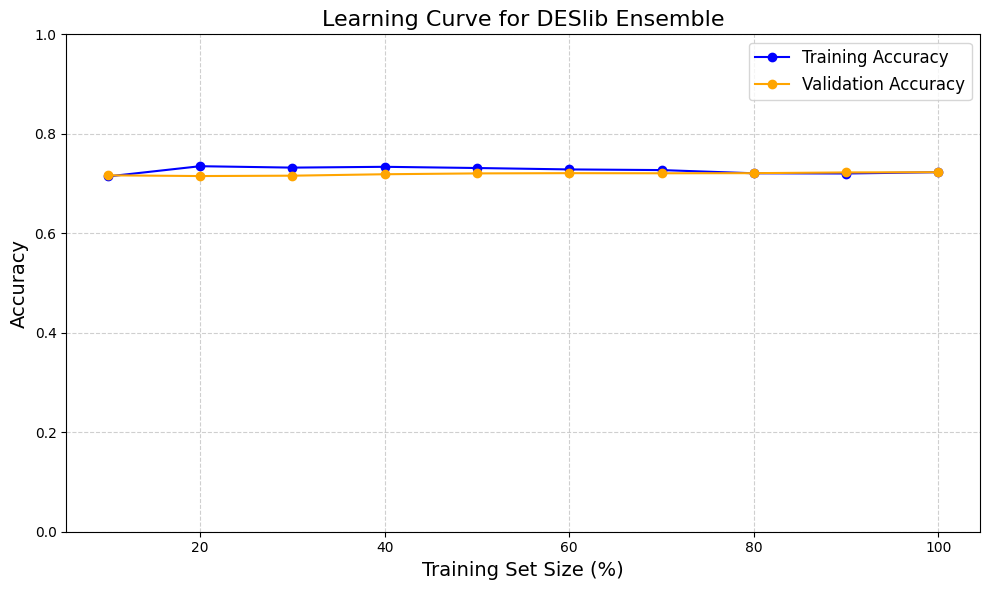

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Proportions of training data to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Initialize lists to store scores
train_scores = []
test_scores = []

# Manually calculate learning curve
for size in train_sizes:
    subset_size = int(size * len(x_test))  # Calculate subset size
    X_subset = x_test[:subset_size]       # Take a subset of training data
    y_subset = y_test[:subset_size]

    knorae.fit(X_subset, y_subset)        # Fit the DESlib model on the subset

    # Predict on training and test subsets
    train_pred = knorae.predict(X_subset)
    test_pred = knorae.predict(x_test)

    # Compute accuracy scores
    train_scores.append(accuracy_score(y_subset, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

# Convert train sizes to percentages for better visualization
train_sizes_percent = train_sizes * 100

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_percent, train_scores, label="Training Accuracy", marker='o', color='blue')
plt.plot(train_sizes_percent, test_scores, label="Validation Accuracy", marker='o', color='orange')

# Add titles, labels, and grid
plt.title("Learning Curve for DESlib Ensemble", fontsize=16)
plt.xlabel("Training Set Size (%)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0.0, 1.0)  # Set y-axis limits (adjust as needed)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min

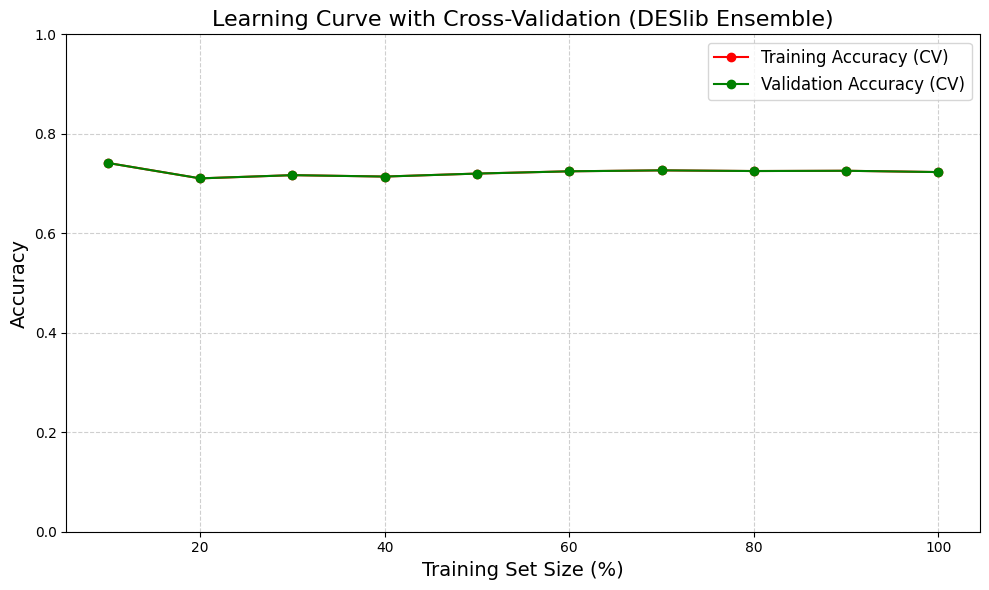

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Assuming you already have your data
# X_train, X_test, y_train, y_test are your training and test sets

# Shuffle the training data before splitting
X_train, y_train = shuffle(x_train, y_train, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)
# Proportions of training data to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Initialize lists to store cross-validated scores
train_scores = []
test_scores = []

# Number of folds for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manually calculate learning curve with cross-validation
for size in train_sizes:
    subset_size = int(size * len(x_dsel))  # Calculate subset size
    X_subset = x_dsel[:subset_size]       # Take a subset of training data
    y_subset = y_dsel[:subset_size]

    # Initialize temporary lists to store fold scores
    cv_train_scores = []
    cv_test_scores = []

    # Perform cross-validation
    for train_idx, val_idx in kf.split(X_subset, y_subset):
        # Split into training and validation folds
        X_train_fold, X_val_fold = X_subset[train_idx], X_subset[val_idx]
        y_train_fold, y_val_fold = y_subset[train_idx], y_subset[val_idx]

        # Fit the model on the training fold
        knorae.fit(X_train_fold, y_train_fold)

        # Predict on the training and validation folds
        train_pred = knorae.predict(X_train_fold)
        val_pred = knorae.predict(X_val_fold)

        # Compute accuracy for the folds
        cv_train_scores.append(accuracy_score(y_train_fold, train_pred))
        cv_test_scores.append(accuracy_score(y_val_fold, val_pred))

    # Average the scores across folds and append to the overall list
    train_scores.append(np.mean(cv_train_scores))
    test_scores.append(np.mean(cv_test_scores))

# Convert train sizes to percentages for better visualization
train_sizes_percent = train_sizes * 100

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_percent, train_scores, label="Training Accuracy (CV)", marker='o', color='r')
plt.plot(train_sizes_percent, test_scores, label="Validation Accuracy (CV)", marker='o', color='g')

# Add titles, labels, and grid
plt.title("Learning Curve with Cross-Validation (DESlib Ensemble)", fontsize=16)
plt.xlabel("Training Set Size (%)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0.0, 1.0)  # Set y-axis limits (adjust as needed)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

**Evaluate the model using class weight since there are imbalance dataset**

In [11]:
from sklearn.utils.class_weight import compute_class_weight
# Classifiers and corresponding transformed test data
classifiers = {
    'KNORA-U': {'model': knorau, 'x_train': x_dsel, 'x_test': x_test},
    'KNORA-E': {'model': knorae, 'x_train': x_dsel, 'x_test': x_test},
    'METADES': {'model': metades, 'x_train': x_dsel, 'x_test': x_test},
}

# Store results
individual_accuracies = []

# Calculate class weights and evaluate classifiers
for name, clf_data in classifiers.items():
    clf = clf_data['model']
    x_train = clf_data['x_train']
    x_test = clf_data['x_test']

    # Calculate class weights based on RFECV-reduced training data
    unique_classes = np.unique(y_dsel)  # Assuming y_train is the same for all classifiers
    weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_dsel
    )
    class_weight_dict = dict(zip(unique_classes, weights))

    # Predict using the current classifier
    y_pred = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', sample_weight=[class_weight_dict[cls] for cls in y_test])
    w_logloss = log_loss(y_test, y_pred_proba, sample_weight=[class_weight_dict[cls] for cls in y_test])
    gmean = geometric_mean_score(y_test, y_pred, average='weighted', sample_weight=[class_weight_dict[cls] for cls in y_test])

    # Append results
    individual_accuracies.append((name, acc, f1, w_logloss, gmean))
    print(f'Accuracy of {name}: {acc:.4f}')
    print(f'F1 Score of {name}: {f1:.4f}')
    print(f'Log loss of {name}: {w_logloss:.4f}')
    print(f'Geometric Mean of {name}: {gmean:.4f}')

# Identify the worst-performing classifier
worst_classifier = min(individual_accuracies, key=lambda x: x[1])
print(f'\nWorst-performing classifier: {worst_classifier[0]} with accuracy: {worst_classifier[1]:.4f}')
print(f'F1 Score of worst-performing classifier: {worst_classifier[2]:.4f}')

# Convert results to DataFrame for easier visualization
columns = ['Classifier', 'Overall Accuracy', 'F1 Score', 'Log Loss', 'Geometric Mean']
result_df = pd.DataFrame(individual_accuracies, columns=columns)
print(result_df)
# Save the DataFrame
result_df.to_csv('C:/Master of Remote Sensing/Python Code/HyperparameterTune_L9/DES_accuracy.csv', index=True)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Accuracy of KNORA-U: 0.7153
F1 Score of KNORA-U: 0.7600
Log loss of KNORA-U: 1.1961
Geometric Mean of KNORA-U: 0.8211
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Accuracy of KNORA-E: 0.7168
F1 Score of KNORA-E: 0.7637
Log loss of KNORA-E: 1.1831
Geometric Mean of KNORA-E: 0.8231
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Accuracy of METADES: 0.7153
F1 Score of METADES: 0.7600
Log loss of METADES: 1.2398
Geometric Mean of METADES: 0.8211

Worst-performing classifier: KNORA-U with accuracy: 0.7153
F1 Score of worst-performing classifier: 0.7600
  Classifier  Overall Accuracy  F1 Score  Log Loss  Geometric Mean
0    KNORA-U          0.715323  0.760020  1.196126        0.821123
1    KNORA-E          0.716776  0.763661  1.183146        0.823106
2    METADES          0.715323  0.760022  1.239752        0.821088


c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [22]:
# Calculate learning curve

train_sizes, train_scores, test_scores = learning_curve(metades, x_dsel, y_dsel, 
                                                        cv=10, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        scoring='neg_log_loss')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))

# Plot the learning curve with confidence intervals
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
# Plot formatting
plt.title('Train Data Learning Curve of KNORAE')
plt.xlabel('Training Size')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='best')
plt.grid()

# Show the plot
plt.show()

ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\deslib\des\meta_des.py", line 202, in fit
    super(METADES, self).fit(X, y)
  File "c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\deslib\base.py", line 100, in fit
    self._check_base_classifier_fitted()
  File "c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\deslib\base.py", line 726, in _check_base_classifier_fitted
    check_is_fitted(clf, "classes_")
  File "c:\Users\62853\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1661, in check_is_fitted
    raise NotFittedError(msg % {"name": type(estimator).__name__})
sklearn.exceptions.NotFittedError: This XGBClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


In [58]:
from sklearn.exceptions import NotFittedError
try:
    best_xgb.predict(x_train, y_train)
except NotFittedError as e:
    print(repr(e))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(metades, x_dsel, y_dsel, 
                                                        cv=10, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        scoring='neg_log_loss')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))

# Plot the learning curve with confidence intervals
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
# Plot formatting
plt.title('Train Data Learning Curve of METADES')
plt.xlabel('Training Size')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='best')
plt.grid()

# Show the plot
plt.show()

**Classified the fitted model and save the result in Tiff format**

In [12]:
import rasterio
from rasterio.transform import from_origin
#The original raster data
loaded_model = knorae
raster= rasterio.open('C:/Master of Remote Sensing/Master Research/Data and Maps/Imagery 2/Landsat 9/Landsat_Combine_Param_final.tif')
#The classification funtion
def classify_raster(raster, model):
    # Reshape raster data into (pixels, bands)
    raster_data = raster.read().reshape((raster.count, -1)).T  # (pixels, bands)
    
    # Handle any invalid or missing data in the raster (e.g., NaN values)
    mask = np.isnan(raster_data).any(axis=1)  # Identify invalid pixels
    classified = np.full(raster_data.shape[0], -1, dtype=int)  # Initialize with a NoData value
    
    # Perform classification on valid pixels only
    classified[~mask] = model.predict(raster_data[~mask])
    
    # Reshape back to raster dimensions
    return classified.reshape((raster.height, raster.width))

# Perform classification
classified_map = classify_raster(raster, loaded_model)
def export_classified_map(classified_map, reference_raster, output_path, nodata_value=-1):
    # Copy metadata from reference raster
    meta = reference_raster.meta.copy()
    
    # Update metadata for classification output
    meta.update({
        "driver": "GTiff",
        "dtype": "int32",
        "count": 1,  # Single band
        "nodata": nodata_value,  # Define NoData value
        "compress": "lzw"
    })
    
    # Export the classified raster
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(classified_map.astype('int32'), 1)
# Classified the raster
output_tif_path = 'C:/Master of Remote Sensing/Python Code/Output_EL/knorae_classified_final_rev.tif'
export_classified_map(classified_map, raster, output_tif_path)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [13]:
import rasterio
from rasterio.transform import from_origin
#The original raster data
loaded_model = metades
raster= rasterio.open('C:/Master of Remote Sensing/Master Research/Data and Maps/Imagery 2/Landsat 9/Landsat_Combine_Param_final.tif')
#The classification funtion
def classify_raster(raster, model):
    # Reshape raster data into (pixels, bands)
    raster_data = raster.read().reshape((raster.count, -1)).T  # (pixels, bands)
    
    # Handle any invalid or missing data in the raster (e.g., NaN values)
    mask = np.isnan(raster_data).any(axis=1)  # Identify invalid pixels
    classified = np.full(raster_data.shape[0], -1, dtype=int)  # Initialize with a NoData value
    
    # Perform classification on valid pixels only
    classified[~mask] = model.predict(raster_data[~mask])
    
    # Reshape back to raster dimensions
    return classified.reshape((raster.height, raster.width))

# Perform classification
classified_map = classify_raster(raster, loaded_model)
def export_classified_map(classified_map, reference_raster, output_path, nodata_value=-1):
    # Copy metadata from reference raster
    meta = reference_raster.meta.copy()
    
    # Update metadata for classification output
    meta.update({
        "driver": "GTiff",
        "dtype": "int32",
        "count": 1,  # Single band
        "nodata": nodata_value,  # Define NoData value
        "compress": "lzw"
    })
    
    # Export the classified raster
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(classified_map.astype('int32'), 1)
# Classified the raster
output_tif_path = 'C:/Master of Remote Sensing/Python Code/Output_EL/metades_classified_final.tif'
export_classified_map(classified_map, raster, output_tif_path)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
